# Confounding Example: Finding causal effects from observed data

Suppose you are given some data with treatment and outcome. Can you determine whether the treatment causes the outcome, or is the correlation purely due to another common cause?

In [ ]:
# Suppress all warnings and messages
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.ERROR)
import os, sys

# Redirect stdout during imports
import io
import contextlib

# Define a context manager to suppress stdout and stderr
@contextlib.contextmanager
def suppress_output():
    # Save the original stdout and stderr
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    # Use StringIO to trap the output
    sys.stdout = io.StringIO()
    sys.stderr = io.StringIO()
    try:
        yield  # Execute the code block inside the with statement
    finally:
        # Restore the original stdout and stderr
        sys.stdout = old_stdout
        sys.stderr = old_stderr

# Suppress output during imports
with suppress_output():
    # Using pip installed dowhy package - no need to modify path
    pass

In [5]:
# Suppress output during imports
with suppress_output():
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math
    import dowhy
    from dowhy.do_why import CausalModel
    import dowhy.datasets, dowhy.plotter
    
# Set matplotlib to not display warnings
plt.rcParams.update({'figure.max_open_warning': 0})

# Let's create a mystery dataset. Need to find if there is a causal effect.

Creating the dataset. It is generated from either of two models:
* **Model 1**: Treatment does cause outcome. 
* **Model 2**: Treatment does not cause outcome. All observed correlation is due to a common cause.

In [6]:
rvar = 1 if np.random.uniform() >0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar, sd_error=0.2)                                               
df = data_dict['df']                                                                                 
print(df[["Treatment", "Outcome", "w0"]].head())                                                                                                     
                                                                                                                                                                                                         

   Treatment    Outcome        w0
0   6.114767  12.860113  0.604129
1   9.354126  19.218313  3.547174
2   4.127611   8.200102 -1.786374
3   2.894128   5.683723 -2.977206
4   9.293877  18.745495  3.314167


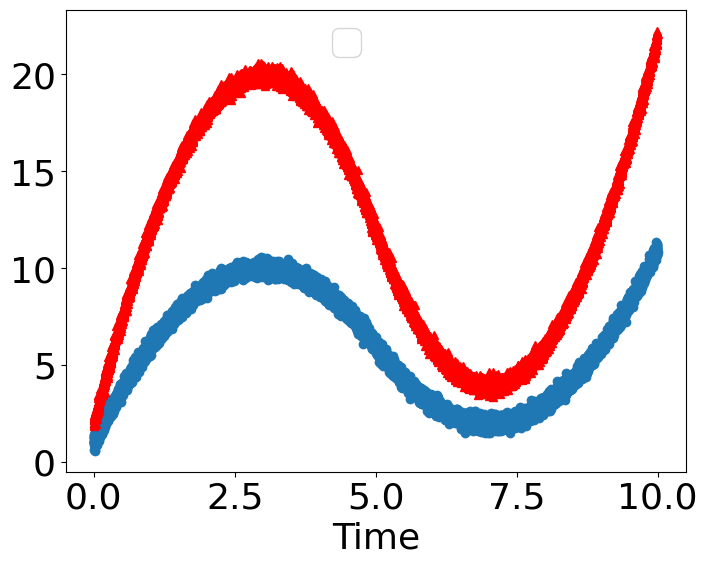

In [7]:
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])                                                       

# Using DoWhy to resolve the mystery: *Does Treatment cause Outcome variable?*
## STEP 1: Model the problem as a causal graph
Initializing the causal model.

Model to find the causal effect of treatment Treatment on outcome Outcome
Using Matplotlib for plotting


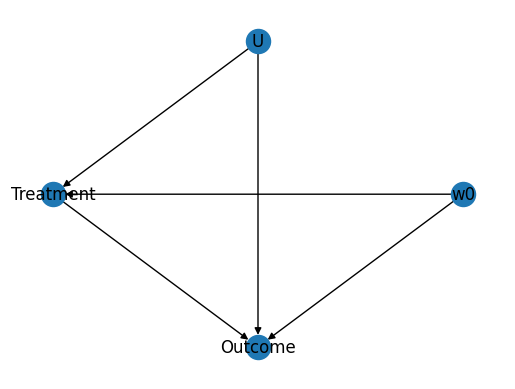

In [8]:
model= CausalModel(                                                                                                                      
        data=df,                                                                                                                         
        treatment=data_dict["treatment_name"],                                                                                           
        outcome=data_dict["outcome_name"],                                                                                               
        common_causes=data_dict["common_causes_names"],                                                                                  
        instruments=data_dict["instrument_names"])                                                                                       
model.view_model(layout="dot")                                                                                                                                                                                                                                             

Showing the causal model stored in local file "causal_model.png"

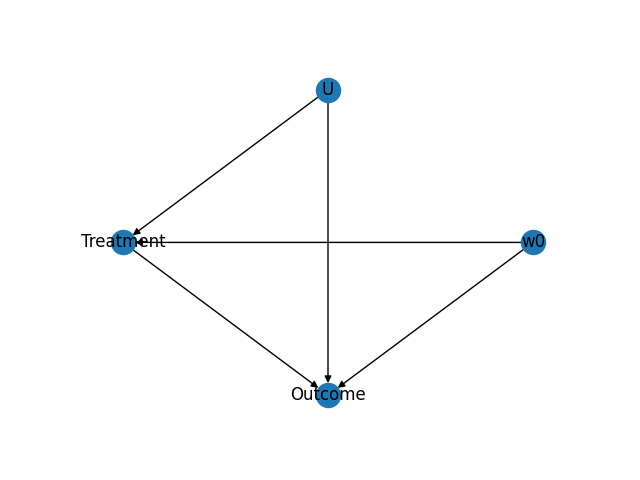

In [9]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## STEP 2: Identify causal effect using properties of the formal causal graph
Identify the causal effect using properties of the causal graph.

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'w0', 'U'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


## STEP 3: Estimate the causal effect

Once we have the identified estimand, can use any statistical method to estimate the causal effect. 

Let's use Linear Regression for simplicity.

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


LinearRegressionEstimator
Causal Estimate is 0.0180444904797


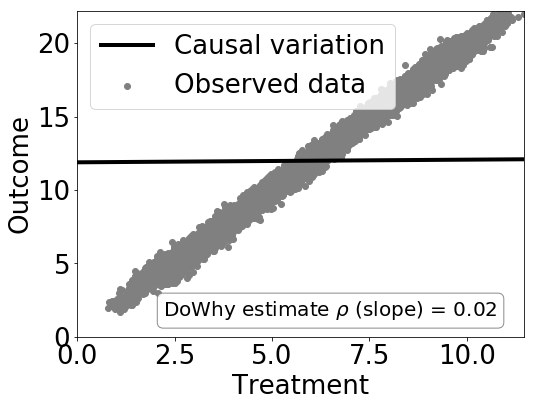

In [ ]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect                                                                                                 
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

### Checking if the estimate is correct

In [ ]:
print("DoWhy estimate is " + str(estimate.value)) 
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is 0.0180444904797
Actual true causal effect was 0


## Step 4: Refuting the estimate

We can also refute the estimate to check its robustness to assumptions (*aka* sensitivity analysis, but on steroids). 

### Adding a random common cause variable

In [ ]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0+w_random


Refute: Add a Random Common Cause
Estimated effect:(0.018044490479725939,)
New effect:(0.017899599388015757,)



### Replacing treatment with a random (placebo) variable

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


Refute: Use a Placebo Treatment
Estimated effect:(0.018044490479725939,)
New effect:(0.00017882059335885532,)



### Removing a random subset of the data

In [ ]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


Refute: Use a subset of data
Estimated effect:(0.018044490479725939,)
New effect:(0.018649516996423924,)



As you can see, our causal estimator is robust to simple refutations.